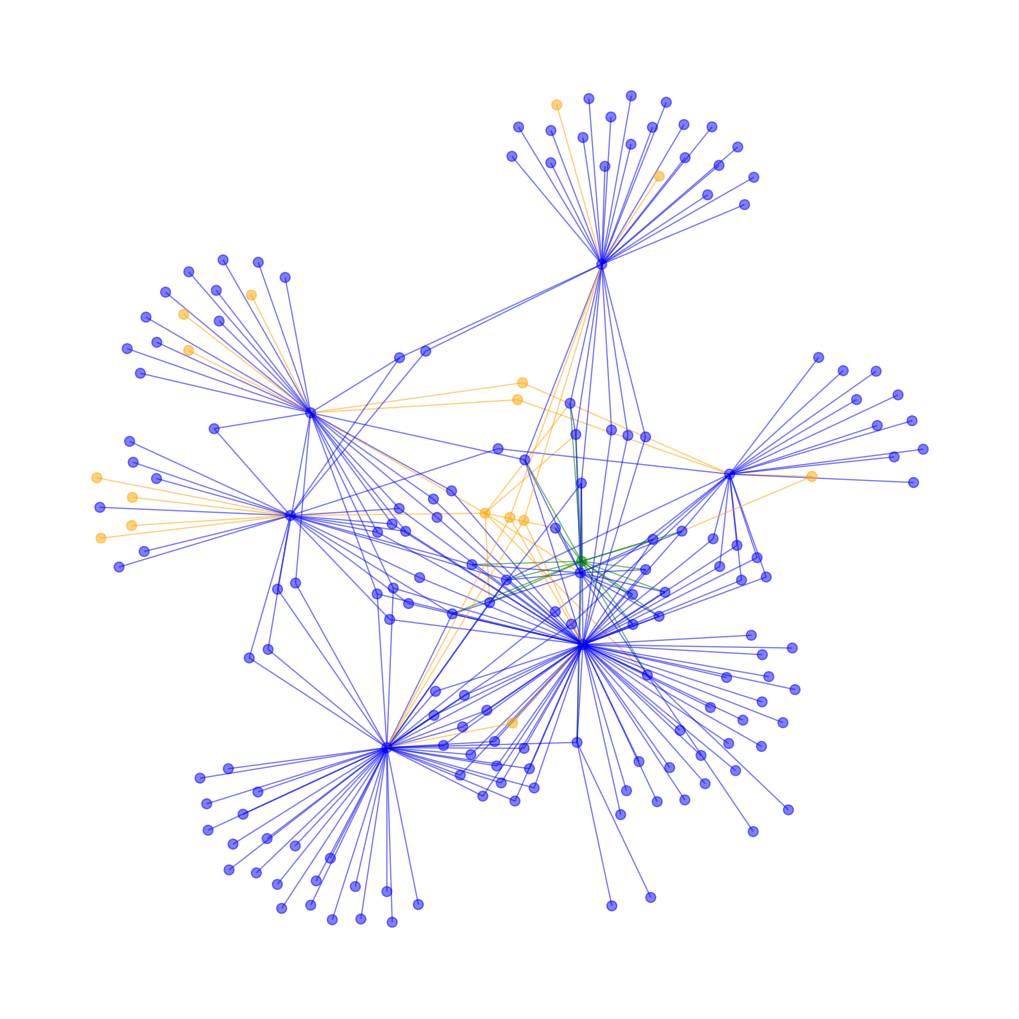

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import time

def draw_graph(G, n_colormap, alpha, labels):
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(G, seed = 1123)
    plt.figure(1, figsize=(10,10))
    e_colors = [G[u][v]['color'] for u,v in G.edges()]
    nx.draw(G, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=alpha, with_labels = labels, font_size = 8, font_weight = 'bold')
    plt.axis('off')
    plt.show()
# nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

# import matplotlib.pyplot as plt
# fig = plt.figure()
# nx.draw(nx_g, with_labels=True)

data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G1 = nx.Graph()

num_vessels = 0
G1_n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
node_att_map['Fish'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'FISH': 1, 'PORT': 2}
eye = np.eye(len(node_att_map))

for ind, data in data_events.iterrows():
    init_vessel = data['vessel_id']
    sec_vessel = data['vessel_id2']
    port = data['port_id']
    event = data['event_type']

    G1.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
    G1_n_colormap[init_vessel] = 'blue'
    
    # if not np.isnan(sec_vessel):
    if not np.isnan(sec_vessel):# and sec_vessel in feature_dict:
        if sec_vessel in feature_dict:
            label = feature_dict[sec_vessel]
            G1.add_node(sec_vessel, name = 'vessel', label = label,
                       one_hot = eye[node_att_map[label]])
        else:
            G1.add_node(sec_vessel, name = 'vessel', label = 'NA',
                       one_hot = eye[node_att_map['NA']])

        G1.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
        G1_n_colormap[sec_vessel] = 'blue'

    elif not np.isnan(port):
        G1.add_node(port, name = 'port', label = 'Port',
                   one_hot = eye[node_att_map['Port']])
        G1.add_edge(init_vessel, port, event = 'PORT', color = 'orange')
        G1_n_colormap[port] = 'orange'
    
    else:
        G1.add_edge(init_vessel, 0, event = event, color = 'green')
        G1_n_colormap[0] = 'green'

G1.nodes[0]['one_hot'] = eye[node_att_map['Fish']]

mapping = {node: ind for ind, node in enumerate(G1.nodes)}
rev_map = {ind: node for ind, node in enumerate(G1.nodes)}

H = nx.relabel_nodes(G1, mapping, copy = True)

node_att = nx.get_node_attributes(H, 'one_hot')
edge_att = nx.get_edge_attributes(H, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G1, seed = 1123)
plt.figure(1, figsize=(10,10))
e_colors = [G1[u][v]['color'] for u,v in G1.edges()]
nx.draw(G1, pos, node_color = G1_n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.5, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

In [3]:
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G2 = nx.Graph()

num_vessels = 0
n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
node_att_map['Fish'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'FISH': 1, 'PORT': 2}
eye = np.eye(len(node_att_map))

def add_to_g(path, G, n_colormap, right = True):
    data_events = pd.read_csv(path)
    for _, data in data_events.iterrows():
        init_vessel = data['vessel_id1']
        sec_vessel = data['vessel_id2']
        event = data['event_type']

        G.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
        n_colormap[init_vessel] = 'blue'
        
        # if not np.isnan(sec_vessel):
        if event == 'ECTR':
            if sec_vessel in feature_dict:
                label = feature_dict[sec_vessel]
                G.add_node(sec_vessel, name = 'vessel', label = label,
                        one_hot = eye[node_att_map[label]])
            else:
                G.add_node(sec_vessel, name = 'vessel', label = 'NA',
                        one_hot = eye[node_att_map['NA']])

            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightblue')
            n_colormap[sec_vessel] = 'blue'

        elif event == 'PORT':
            G.add_node(sec_vessel, name = 'port', label = 'Port',
                    one_hot = eye[node_att_map['Port']])
            
            if right:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'red')
            else:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'pink')
            n_colormap[sec_vessel] = 'red'
        
        else:
            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'green')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightgreen')
            n_colormap[0] = 'green'
    return G

path1 = 'res/right_data.csv'
G2 = add_to_g(path1, G2, n_colormap, True)
path2 = 'res/wrong_data.csv'
G2 = add_to_g(path2, G2, n_colormap, False)
G2.nodes[0]['one_hot'] = eye[node_att_map['Fish']]


mapping = {node: ind for ind, node in enumerate(G2.nodes)}
rev_map = {ind: node for ind, node in enumerate(G2.nodes)}

H2 = nx.relabel_nodes(G2, mapping, copy = True)

node_att = nx.get_node_attributes(H2, 'one_hot')
edge_att = nx.get_edge_attributes(H2, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H2.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G2)
plt.figure(1, figsize=(10,10))
e_colors = [G2[u][v]['color'] for u,v in G2.edges()]
nx.draw(G2, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.7, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

FileNotFoundError: [Errno 2] No such file or directory: 'res/right_data.csv'

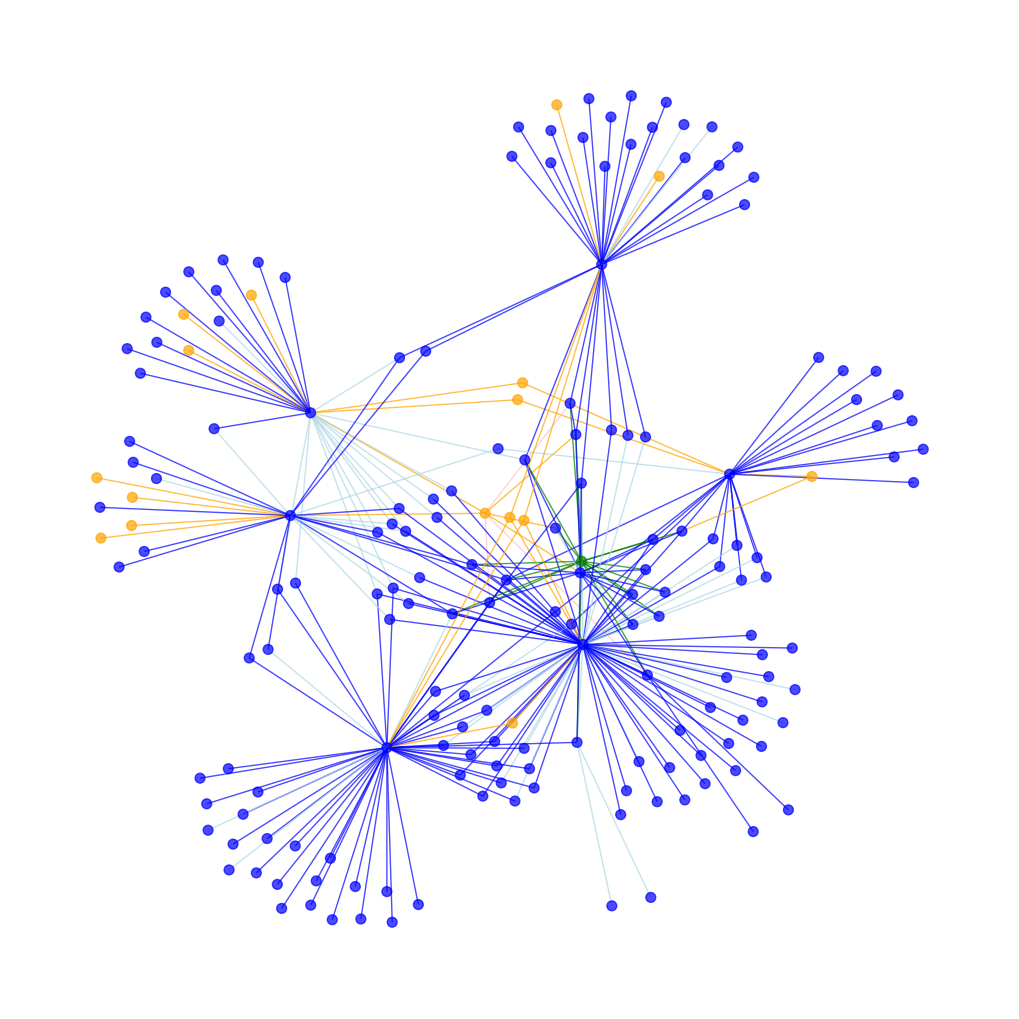

In [8]:
from copy import deepcopy

Gwrong = nx.Graph()
n_colormap = {}
G1_copy = deepcopy(G1)

path2 = 'res/wrong_data.csv'
Gwrong = add_to_g(path2, Gwrong, n_colormap, False)
G1_copy.update(Gwrong.edges(data=True), Gwrong.nodes(data=True))
draw_graph(G1_copy, G1_n_colormap, 0.7, False)

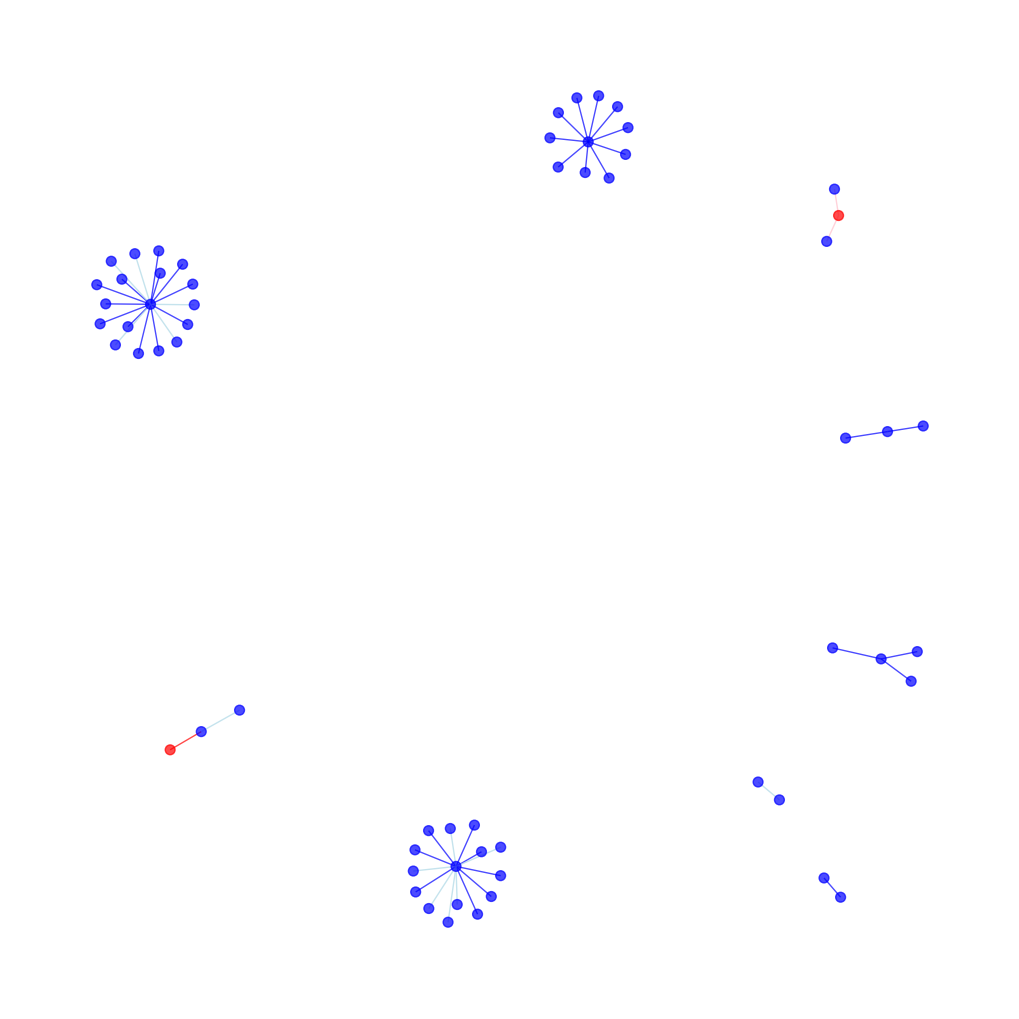

In [17]:
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G2 = nx.Graph()

num_vessels = 0
n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'PORT': 1}
eye = np.eye(len(node_att_map))

def add_to_g(path, G, n_colormap, right = True):
    data_events = pd.read_csv(path)
    for _, data in data_events.iterrows():
        init_vessel = data['vessel_id1']
        sec_vessel = data['vessel_id2']
        event = data['event_type']

        G.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
        n_colormap[init_vessel] = 'blue'
        
        # if not np.isnan(sec_vessel):
        if event == 'ECTR':
            if sec_vessel in feature_dict:
                label = feature_dict[sec_vessel]
                G.add_node(sec_vessel, name = 'vessel', label = label,
                        one_hot = eye[node_att_map[label]])
            else:
                G.add_node(sec_vessel, name = 'vessel', label = 'NA',
                        one_hot = eye[node_att_map['NA']])

            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightblue')
            n_colormap[sec_vessel] = 'blue'

        elif event == 'PORT':
            G.add_node(sec_vessel, name = 'port', label = 'Port',
                    one_hot = eye[node_att_map['Port']])
            
            if right:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'red')
            else:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'pink')
            n_colormap[sec_vessel] = 'red'
        
    return G

path1 = 'res/right_data_fish.csv'
G2 = add_to_g(path1, G2, n_colormap, True)
path2 = 'res/wrong_data_fish.csv'
G2 = add_to_g(path2, G2, n_colormap, False)


mapping = {node: ind for ind, node in enumerate(G2.nodes)}
rev_map = {ind: node for ind, node in enumerate(G2.nodes)}

H2 = nx.relabel_nodes(G2, mapping, copy = True)

node_att = nx.get_node_attributes(H2, 'one_hot')
edge_att = nx.get_edge_attributes(H2, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H2.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G2, seed=1123)
plt.figure(1, figsize=(10,10))
e_colors = [G2[u][v]['color'] for u,v in G2.edges()]
nx.draw(G2, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.7, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

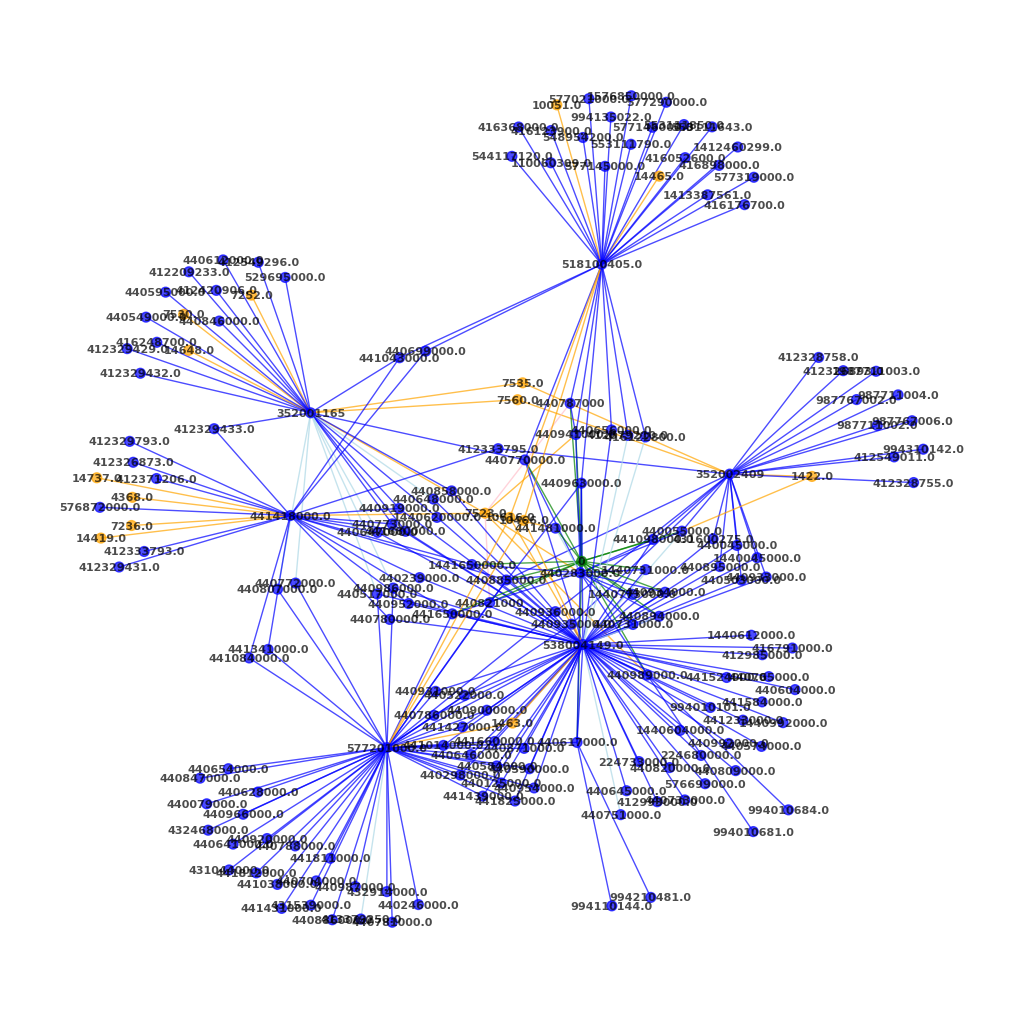

In [14]:
from copy import deepcopy

Gwrong = nx.Graph()
n_colormap = {}
G1_copy = deepcopy(G1)
#G1_copy.remove_node(0)

G1_copy_colormap = deepcopy(G1_n_colormap)

path2 = 'res/wrong_data_fish.csv'
Gwrong = add_to_g(path2, Gwrong, n_colormap, False)
G1_copy.update(Gwrong.edges(data=True), Gwrong.nodes(data=True))
del G1_copy_colormap[0]
draw_graph(G1_copy, G1_n_colormap, 0.7, True)